# 1. Introduction

Airbnb is an online marketplace that connects people who are looking for a place to stay with individuals who have a spare room or property to rent out. Founded in 2008, Airbnb has become a popular platform for travelers to find unique and affordable accommodations all around the world. Hosts can list their properties on the website and set their own prices and availability, while guests can search for listings based on their preferences and book directly with the host. Airbnb offers a range of different types of accommodations, from private rooms in a shared apartment to entire houses and apartments. The platform also provides a review system, allowing guests to leave feedback on their stay and helping hosts build a positive reputation.





# 2. Librairies and Data extraction

In [57]:
# data analysis
import pandas as pd
import numpy as np

# data visualization

import seaborn as sns
import matplotlib.pyplot  as plt
import missingno as msno

from scipy.stats import norm
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error


In [58]:
#from google.colab import drive
#drive.mount('/content/drive')


In [59]:
#path = '/content/drive/MyDrive/T2-DSBA/Ensemble/airbnb/AB_NYC_2019.csv'

In [61]:
df = pd.read_csv('/Users/Koko/Desktop/DSBA/T2/Ensemble_Learning/Project /Dataset /AB_NYC_2019.csv')


Let us examine the dataset

In [62]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [63]:
zero_price = df[df['price'] == 0]
print(len(zero_price))

df = df[df['price']>0]
zero_price = df[df['price'] == 0]
print(len(zero_price))

11
0


In [64]:
# Convert the last_review column to datetime format
df['last_review'] = pd.to_datetime(df['last_review'])


In [65]:
# Replace NaN values in 'last_review' with the minimum date

min_date = df['last_review'].min()
df['last_review'] = df['last_review'].fillna(min_date)

In [66]:
# Host activity level
df['host_activity'] = df.groupby('host_id')['calculated_host_listings_count'].transform('sum')

In [67]:
# Days since last review
df['time_since_last_review'] = (pd.to_datetime('today') - df['last_review']).dt.days

# Create new features for dates
df['last_review_year'] = pd.to_datetime(df['last_review']).dt.year
df['last_review_month'] = pd.to_datetime(df['last_review']).dt.month
df['last_review_dayofweek'] = df['last_review'].dt.dayofweek

Our goal is to predict our target variable - price based on the other features

In [68]:
#Size of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48884 entries, 0 to 48894
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              48884 non-null  int64         
 1   name                            48868 non-null  object        
 2   host_id                         48884 non-null  int64         
 3   host_name                       48863 non-null  object        
 4   neighbourhood_group             48884 non-null  object        
 5   neighbourhood                   48884 non-null  object        
 6   latitude                        48884 non-null  float64       
 7   longitude                       48884 non-null  float64       
 8   room_type                       48884 non-null  object        
 9   price                           48884 non-null  int64         
 10  minimum_nights                  48884 non-null  int64         
 11  nu

In [69]:
# Descriptive statistics of our variables

df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,host_activity,time_since_last_review,last_review_year,last_review_month,last_review_dayofweek
count,4.888400e+04,4.888400e+04,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,38833.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000
mean,1.901679e+07,6.762203e+07,40.728953,-73.952176,152.755053,7.029887,23.271991,1.373128,7.144628,112.779498,1137.130595,2196.766999,2016.789236,5.521254,2.560101
std,1.098432e+07,7.861666e+07,0.054532,0.046159,240.170260,20.512224,44.551331,1.680391,32.956185,131.627271,9505.331703,1169.920057,3.127822,2.595818,2.391163
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,10.000000,1.000000,0.000000,0.010000,1.000000,0.000000,1.000000,1355.000000,2011.000000,1.000000,0.000000
25%,9.470548e+06,7.817310e+06,40.690100,-73.983080,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000,1.000000,1374.000000,2016.000000,3.000000,0.000000
50%,1.967574e+07,3.079257e+07,40.723080,-73.955685,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000,1.000000,1541.000000,2019.000000,6.000000,2.000000
75%,2.915297e+07,1.074344e+08,40.763120,-73.936290,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000,4.000000,2556.000000,2019.000000,7.000000,5.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000,106929.000000,4379.000000,2019.000000,12.000000,6.000000


In [70]:
# Variable types
    
df.dtypes.value_counts()

int64             12
object             5
float64            3
datetime64[ns]     1
dtype: int64

In [71]:
df.columns 

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'host_activity', 'time_since_last_review',
       'last_review_year', 'last_review_month', 'last_review_dayofweek'],
      dtype='object')

# 3. Data Cleaning

### 3.a) Dealing with missing values 

In [72]:
df.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                           0
reviews_per_month                 10051
calculated_host_listings_count        0
availability_365                      0
host_activity                         0
time_since_last_review                0
last_review_year                      0
last_review_month                     0
last_review_dayofweek                 0
dtype: int64

<AxesSubplot:>

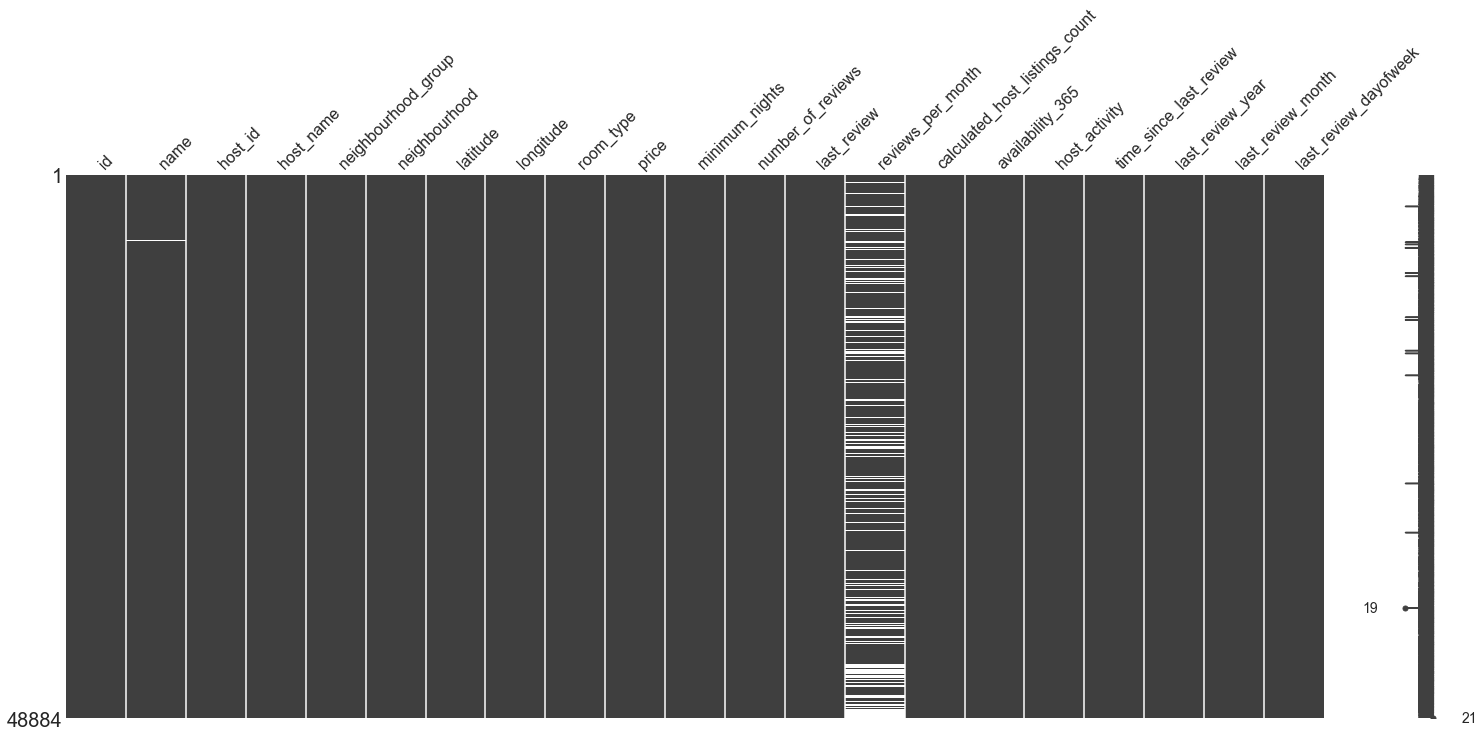

In [73]:
#Visualization for missing values
msno.matrix(df)

The feature "reviews_per_month" contains some incomplete data which will be substituted with the mean.

In [74]:
mean = df['reviews_per_month'].mean()
df['reviews_per_month'].fillna(mean, inplace=True)
df.isnull().sum()

id                                 0
name                              16
host_id                            0
host_name                         21
neighbourhood_group                0
neighbourhood                      0
latitude                           0
longitude                          0
room_type                          0
price                              0
minimum_nights                     0
number_of_reviews                  0
last_review                        0
reviews_per_month                  0
calculated_host_listings_count     0
availability_365                   0
host_activity                      0
time_since_last_review             0
last_review_year                   0
last_review_month                  0
last_review_dayofweek              0
dtype: int64

For our analysis, we won't need the following features : host_name and id. Therefore, we drop it from out dataframe

In [75]:
df = df.drop(columns=['host_name','id'])
df.head()

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,host_activity,time_since_last_review,last_review_year,last_review_month,last_review_dayofweek
0,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.210000,6,365,36,1617,2018,10,4
1,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.380000,2,355,4,1403,2019,5,1
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,2011-03-28,1.373128,1,365,1,4379,2011,3,0
3,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.640000,1,194,1,1358,2019,7,4
4,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.100000,1,0,1,1586,2018,11,0


### 3.b) Data Transformation 

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Price Distribution Plot')

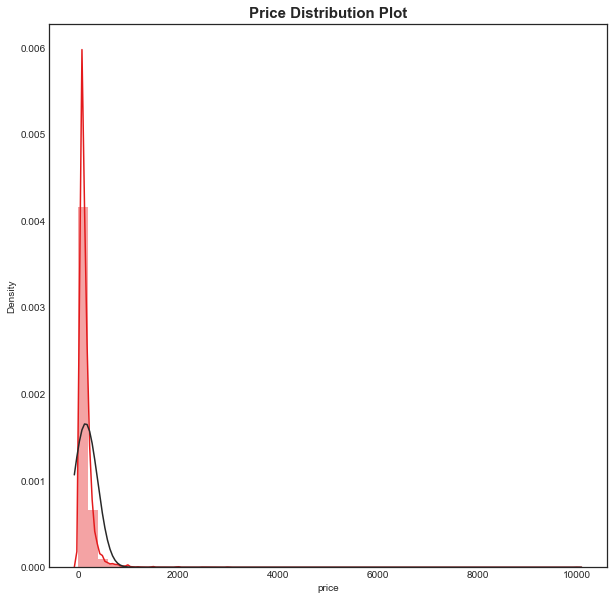

In [76]:
plt.figure(figsize=(10,10))
sns.distplot(df['price'], fit=norm)
plt.title("Price Distribution Plot",size=15, weight='bold')

The distribution graph depicted above indicates that the price feature follows a right-skewed distribution with a positive skewness. To mitigate this skewness and improve the interpretability and statistical analysis of the data, a log transformation will be applied to the feature. However, as division by zero is a potential issue, a log+1 transformation would be more suitable in this case.





In [77]:
df['price_log'] = np.log(df.price)


By transorming price into log_price, price feature shows a normal distribution

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Price Distribution Plot')

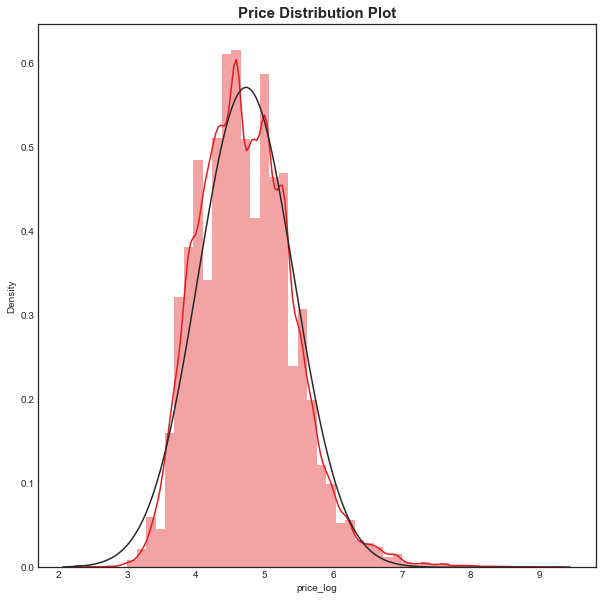

In [78]:
plt.figure(figsize=(10,10))
sns.distplot(df['price_log'], fit=norm)
plt.title("Price Distribution Plot",size=15, weight='bold')

### 3.c) Visualizing and dealing with outliers

Text(0.5, 1.0, 'reviews_per_month')

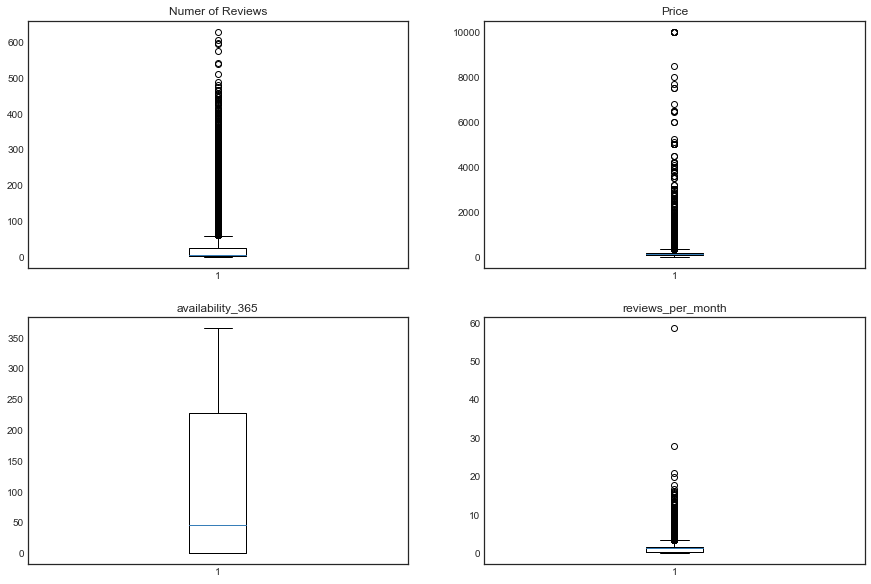

In [79]:
plt.figure(figsize = (15, 10))
plt.style.use('seaborn-white')
ax=plt.subplot(221)
plt.boxplot(df['number_of_reviews'])
ax.set_title('Numer of Reviews')
ax=plt.subplot(222)
plt.boxplot(df['price'])
ax.set_title('Price')
ax=plt.subplot(223)
plt.boxplot(df['availability_365'])
ax.set_title('availability_365')
ax=plt.subplot(224)
plt.boxplot(df['reviews_per_month'])
ax.set_title('reviews_per_month')

All variables except availability_365 have a lot of outliers. We will get rid of them by using the inter quantile range in order to simplify our analysis 

In [80]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filter = (df['price'] >= Q1 - 1.5 * IQR) & (df['price'] <= Q3 + 1.5 *IQR)
df1=df.loc[filter]

Q1 = df1['number_of_reviews'].quantile(0.25)
Q3 = df1['number_of_reviews'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filter = (df1['number_of_reviews'] >= Q1 - 1.5 * IQR) & (df1['number_of_reviews'] <= Q3 + 1.5 *IQR)
df2=df1.loc[filter]


Q1 = df2['reviews_per_month'].quantile(0.25)
Q3 = df2['reviews_per_month'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filter = (df2['reviews_per_month'] >= Q1 - 1.5 * IQR) & (df2['reviews_per_month'] <= Q3 + 1.5 *IQR)
df_new=df2.loc[filter]

Text(0.5, 1.0, 'reviews_per_month')

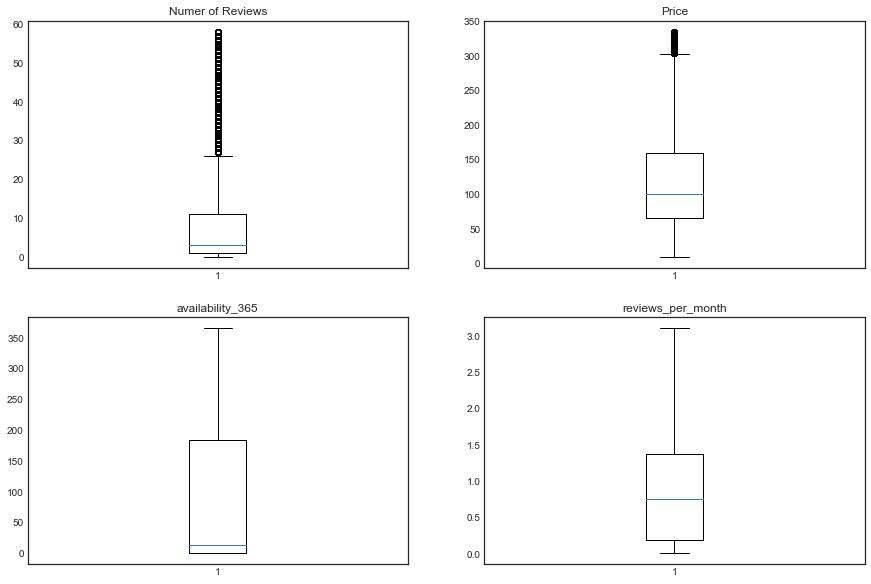

In [81]:
plt.figure(figsize = (15, 10))
plt.style.use('seaborn-white')
ax=plt.subplot(221)
plt.boxplot(df_new['number_of_reviews'])
ax.set_title('Numer of Reviews')
ax=plt.subplot(222)
plt.boxplot(df_new['price'])
ax.set_title('Price')
ax=plt.subplot(223)
plt.boxplot(df_new['availability_365'])
ax.set_title('availability_365')
ax=plt.subplot(224)
plt.boxplot(df_new['reviews_per_month'])
ax.set_title('reviews_per_month')

# 4. Data Exploratory Analysis


This graph will enable us to count categorical variables with bar charts

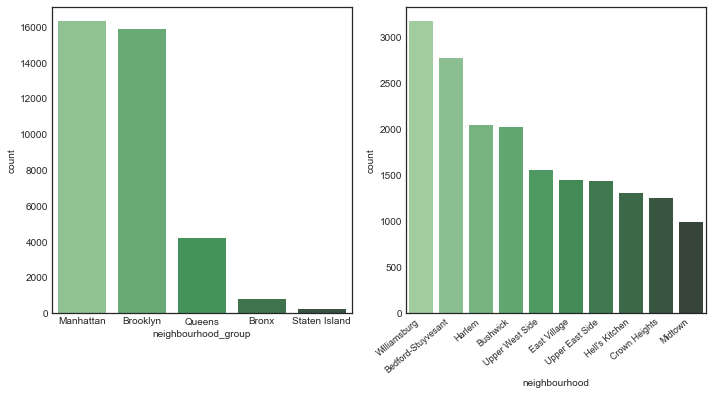

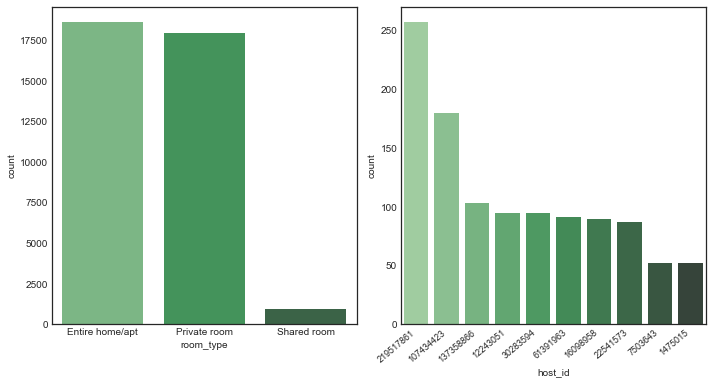

In [25]:
plt.figure(figsize = (15, 7))
plt.style.use('seaborn-white')
#Neighbourhood group
plt.subplot(221)
sns.countplot(x="neighbourhood_group", data=df_new, palette="Greens_d",
              order=df_new.neighbourhood_group.value_counts().index)
fig = plt.gcf()
fig.set_size_inches(10,10)

#Top 10 Neighbourhood
plt.subplot(222)
ax=sns.countplot(x="neighbourhood", data=df_new, palette="Greens_d",
              order=df_new.neighbourhood.value_counts().iloc[:10].index)
fig = plt.gcf()
fig.set_size_inches(10,10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=9)
plt.tight_layout()
plt.show()

#Room type
plt.subplot(223)
sns.countplot(x="room_type", data=df_new, palette="Greens_d",
              order=df_new.room_type.value_counts().index)
fig = plt.gcf()
fig.set_size_inches(10,10)

#Top 10 hosts
plt.subplot(224)
ax=sns.countplot(x="host_id", data=df_new, palette="Greens_d",
              order=df_new.host_id.value_counts().iloc[:10].index)
fig = plt.gcf()
fig.set_size_inches(10,10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=9)
plt.tight_layout()
plt.show()


When looking at the location-based on the neighborhood group, Manhattan and Brooklyn are ranked first and second, respectively, based on the size and the number of people who have booked a room. Following them in rank are Queens, Bronx, and Staten Island. Additionally, the top 10 areas based on neighborhood are also displayed, with Williamsburg ranking first with almost 3000 bookings.

In terms of the type of room booked, most bookings were for entire homes, with private and shared rooms being less common. Finally, the user with the highest number of bookings is associated with the host ID 219517861, making them the best customer of Airbnb in New York.

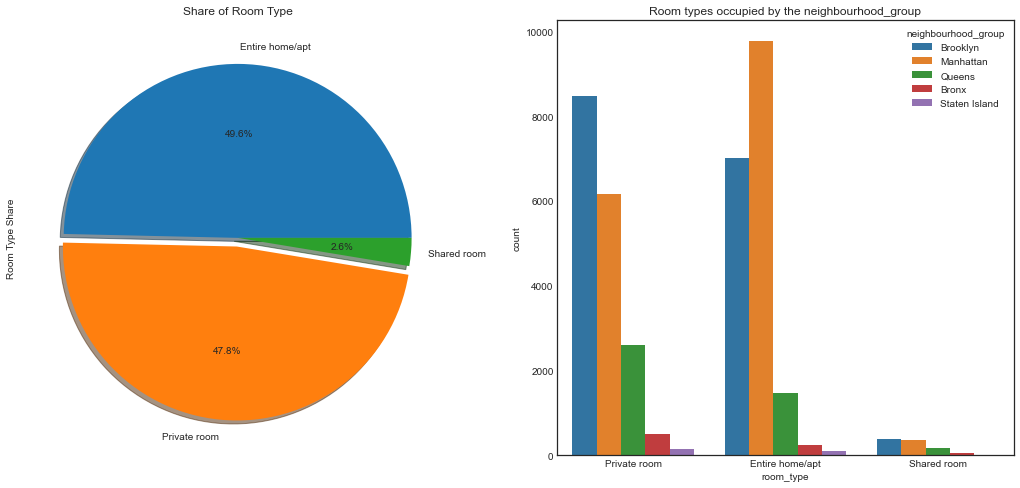

In [26]:
plt.style.use('seaborn-white')
f,ax=plt.subplots(1,2,figsize=(18,8))
df_new['room_type'].value_counts().plot.pie(explode=[0,0.05,0],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Share of Room Type')
ax[0].set_ylabel('Room Type Share')
sns.countplot(x = 'room_type',hue = "neighbourhood_group",data = df_new)
ax[1].set_title('Room types occupied by the neighbourhood_group')
plt.show()

From the graph above, we can state that shared rooms are very less prefered compared to the other room types. 
In Brooklyn, guests tend to book private rooms while in Manhattan, they would rather book entire homes and appartments.

The next graph is about relationship between price and room type. Shared room prices are always lower than $2000 while private rooms and entire homes have the highest prices. We decided to keep outliers for the following graphs in order to have more insights on airbnb properties

Text(0.5, 1.0, 'Room Type vs Price')

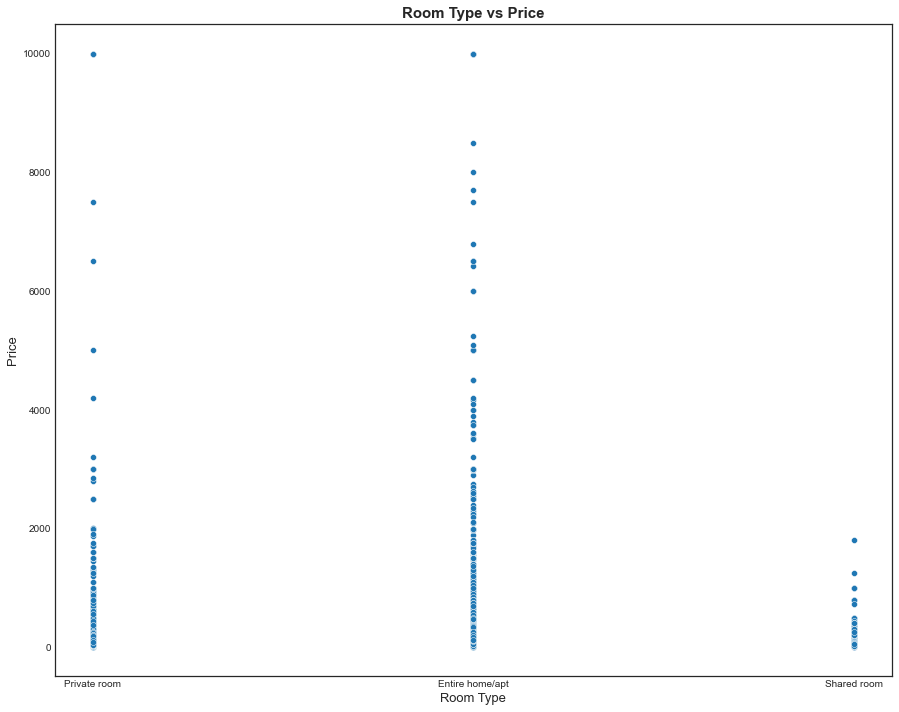

In [27]:
plt.figure(figsize=(15,12))
sns.scatterplot(x='room_type', y='price', data=df)

plt.xlabel("Room Type", size=13)
plt.ylabel("Price", size=13)
plt.title("Room Type vs Price",size=15, weight='bold')

The next graph depicts the relationship between neighborhood group, room type, and price. In Manhattan, the Private Room and Entire Home/Apt have the highest prices, while Brooklyn boasts very high prices for both room types. In contrast, the highest price for a shared room is found in the Queens area.


Text(0.5, 1.0, 'Room Type vs Price vs Neighbourhood Group')

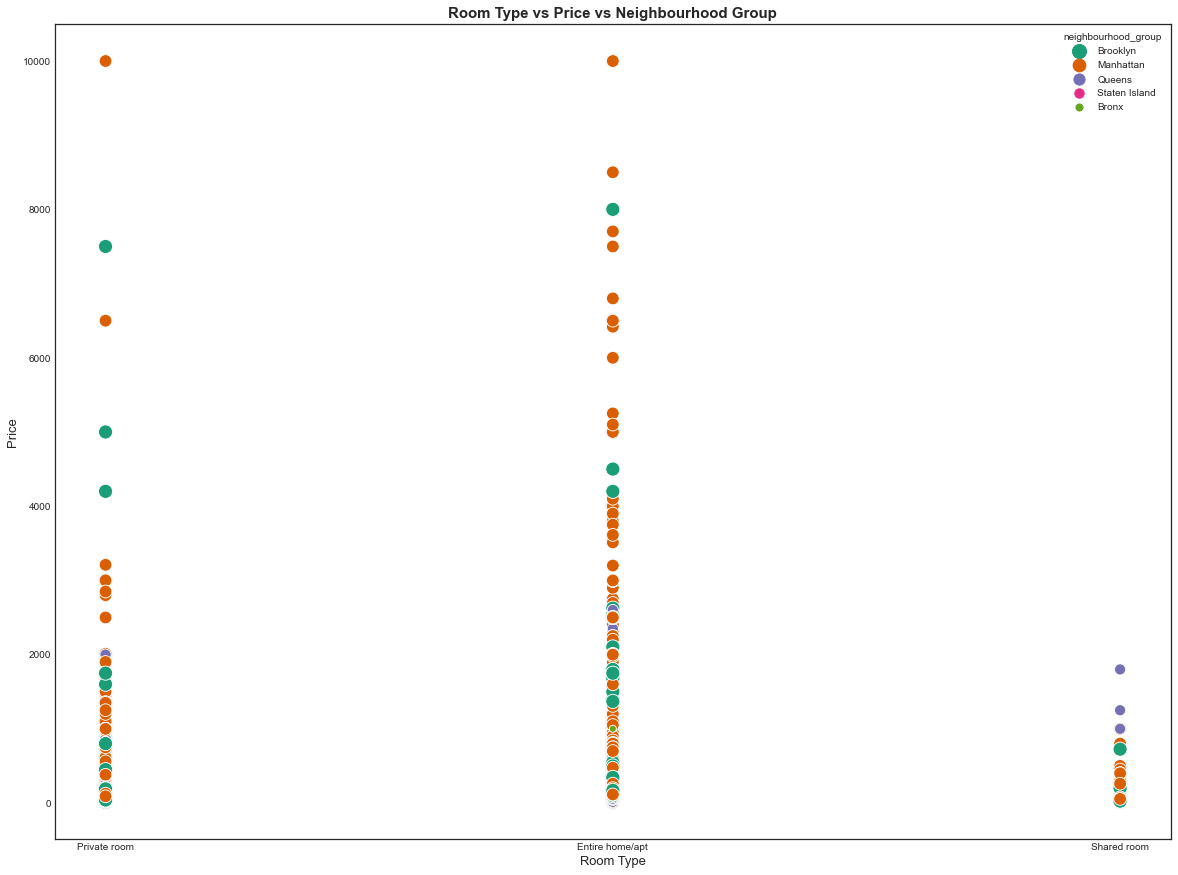

In [28]:
plt.figure(figsize=(20,15))
sns.scatterplot(x="room_type", y="price",
            hue="neighbourhood_group", size="neighbourhood_group",
            sizes=(50, 200), palette="Dark2", data=df)

plt.xlabel("Room Type", size=13)
plt.ylabel("Price", size=13)
plt.title("Room Type vs Price vs Neighbourhood Group",size=15, weight='bold')

The next graph displays the correlation between the price and the number of reviews in each neighborhood group. Surprisingly, the graph demonstrates that lower-priced accommodations have received more reviews than higher-priced ones, revealing a negative correlation between price and the number of reviews. Moreover, the Manhattan, Brooklyn, and Queens areas have significantly higher review counts than other areas.





Text(0.5, 1.0, 'Price vs Number of Reviews vs Neighbourhood Group')

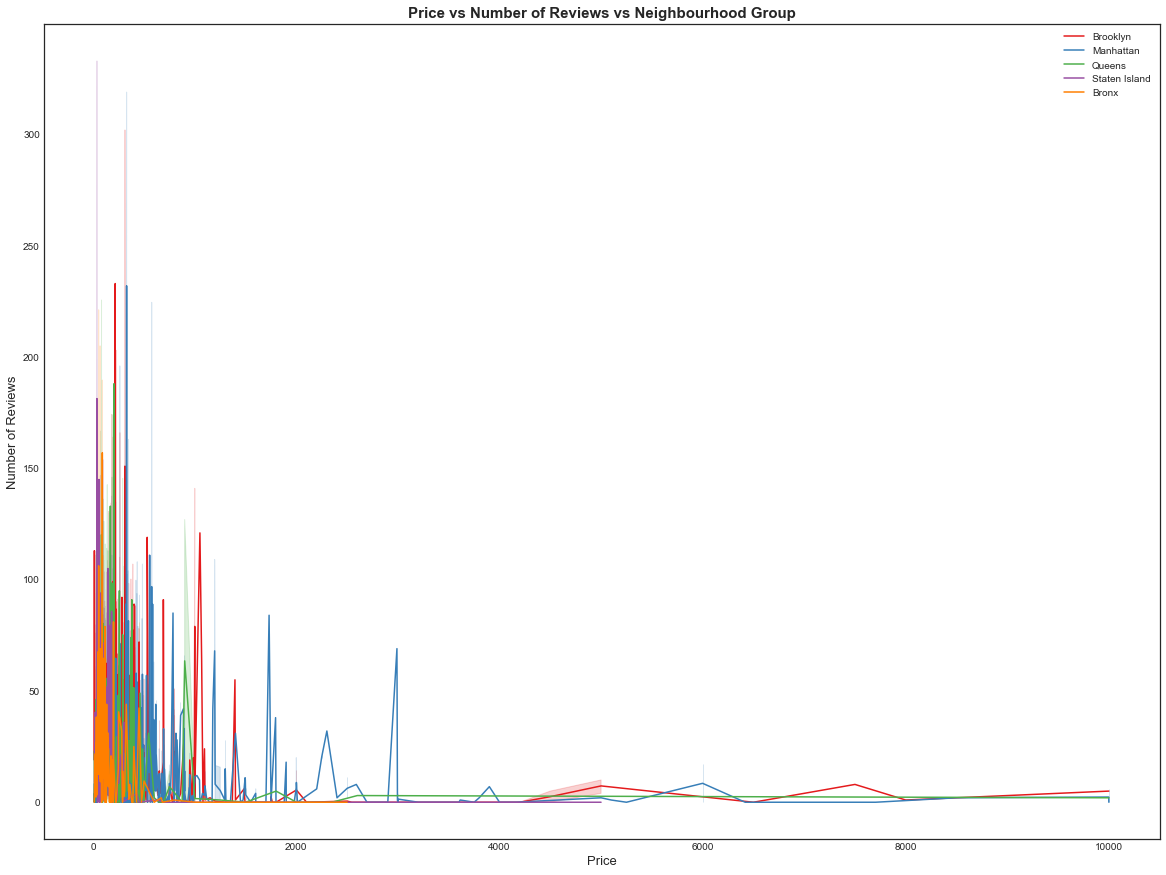

In [29]:
plt.figure(figsize=(20,15))
sns.set_palette("Set1")

sns.lineplot(x='price', y='number_of_reviews', 
             data=df[df['neighbourhood_group']=='Brooklyn'],
             label='Brooklyn')
sns.lineplot(x='price', y='number_of_reviews', 
             data=df[df['neighbourhood_group']=='Manhattan'],
             label='Manhattan')
sns.lineplot(x='price', y='number_of_reviews', 
             data=df[df['neighbourhood_group']=='Queens'],
             label='Queens')
sns.lineplot(x='price', y='number_of_reviews', 
             data=df[df['neighbourhood_group']=='Staten Island'],
             label='Staten Island')
sns.lineplot(x='price', y='number_of_reviews', 
             data=df[df['neighbourhood_group']=='Bronx'],
             label='Bronx')
plt.xlabel("Price", size=13)
plt.ylabel("Number of Reviews", size=13)
plt.title("Price vs Number of Reviews vs Neighbourhood Group",size=15, weight='bold')

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

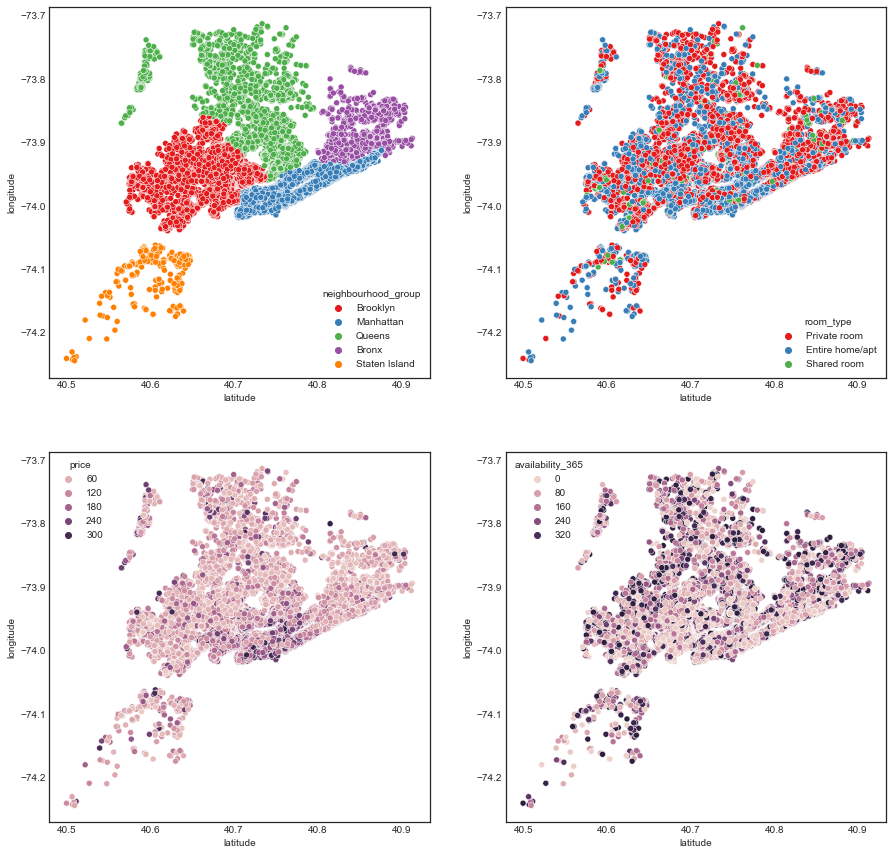

In [30]:
plt.figure(figsize = (15, 15))
plt.style.use('seaborn-white')
plt.subplot(221)
sns.scatterplot(x="latitude", y="longitude",hue="neighbourhood_group", data=df_new)
plt.subplot(222)
sns.scatterplot(x="latitude", y="longitude",hue="room_type", data=df_new)
plt.subplot(223)
sns.scatterplot(x="latitude", y="longitude",hue="price", data=df_new)
plt.subplot(224)
sns.scatterplot(x="latitude", y="longitude",hue="availability_365", data=df_new)

From the top corner right plot, we can infer that shared rooms represent a small proportions of the room types, as we said earlier. 

On the bottom left corner graph, we can infer that most of the expensives properties are located in Manhattan. 

Finally, from the last graph on the bottom right corner graph, we can say that there is more availability for airbnb bookings on all the boroughs of New York, except Manhattan where probably most of the tourists book their stay. 


Let us consider that a airbnb host with more than 50 reviews is considered as a top host. The following graph shows the locations of the top hosts 

In [31]:
import geopandas as gpd
import math
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

number_of_reviews = df_new[(df_new.number_of_reviews.isin(range(50,58)))]
# Creating a map
m_2 = folium.Map(location=[40.7128,-74.0060], tiles='cartodbpositron', zoom_start=13)

# Adding points to the map
for idx, row in number_of_reviews.iterrows():
    Marker([row['latitude'], row['longitude']]).add_to(m_2)

# Displaying the map
m_2

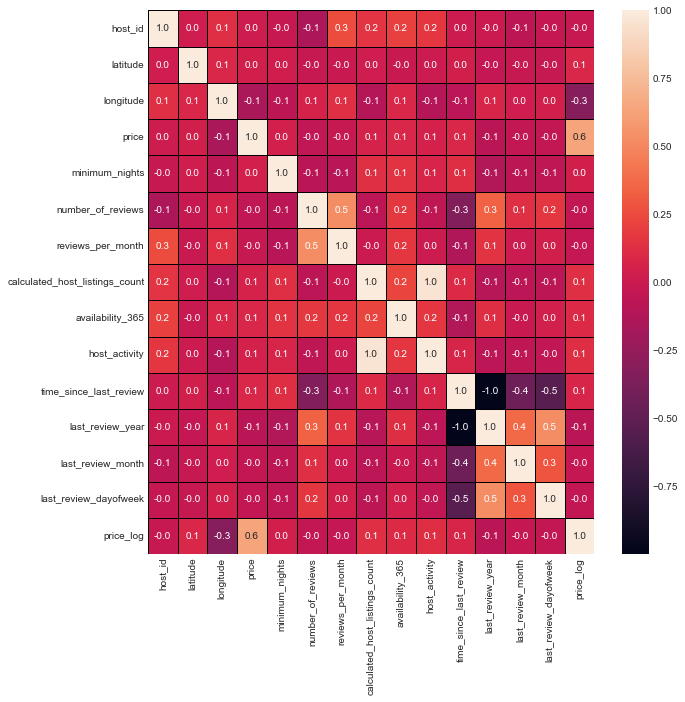

In [82]:
f,ax=plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(),annot=True,linewidths=0.5,linecolor="black",fmt=".1f",ax=ax)
plt.show()

From this map, we can say that in general the variables are not strongly correlated. Only number_of_reviews and reviews_per_month have a positive correlation. 

In [83]:
df.head()

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,host_activity,time_since_last_review,last_review_year,last_review_month,last_review_dayofweek,price_log
0,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.210000,6,365,36,1617,2018,10,4,5.003946
1,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.380000,2,355,4,1403,2019,5,1,5.416100
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,2011-03-28,1.373128,1,365,1,4379,2011,3,0,5.010635
3,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.640000,1,194,1,1358,2019,7,4,4.488636
4,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.100000,1,0,1,1586,2018,11,0,4.382027


We can now select our features for the modelling part

# 5. Feature selection and modelling

## 5.a) Feature selection

In [84]:
df_features=df_new[['latitude','longitude','neighbourhood_group','room_type','availability_365','minimum_nights','host_activity','reviews_per_month','number_of_reviews','time_since_last_review']]
df_features.head()

,latitude,longitude,neighbourhood_group,room_type,availability_365,minimum_nights,host_activity,reviews_per_month,number_of_reviews,time_since_last_review
0,40.64749,-73.97237,Brooklyn,Private room,365,1,36,0.210000,9,1617
1,40.75362,-73.98377,Manhattan,Entire home/apt,355,1,4,0.380000,45,1403
2,40.80902,-73.94190,Manhattan,Private room,365,3,1,1.373128,0,4379
4,40.79851,-73.94399,Manhattan,Entire home/apt,0,10,1,0.100000,9,1586
6,40.68688,-73.95596,Brooklyn,Private room,0,45,1,0.400000,49,1996


In [85]:
# Calculate the total number of reviews per neighbourhood
reviews_per_neighbourhood = df_features.groupby('neighbourhood_group')['number_of_reviews'].sum()

# Calculate the total number of listings per neighbourhood
listings_per_neighbourhood = df_features.groupby('neighbourhood_group').size()

# Calculate the average number of reviews per month per neighbourhood
avg_reviews_per_month_per_neighbourhood = reviews_per_neighbourhood / (30 * listings_per_neighbourhood)

# Create a new feature "Neighbourhood popularity"
df_features['neighbourhood_popularity'] = df_features['neighbourhood_group'].map(avg_reviews_per_month_per_neighbourhood)

# Print the first five rows of the dataframe to verify the new feature
df_features.head()

/var/folders/l0/0cgxskj930n41kt48_snr5600000gn/T/ipykernel_52060/4239976737.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['neighbourhood_popularity'] = df_features['neighbourhood_group'].map(avg_reviews_per_month_per_neighbourhood)


,latitude,longitude,neighbourhood_group,room_type,availability_365,minimum_nights,host_activity,reviews_per_month,number_of_reviews,time_since_last_review,neighbourhood_popularity
0,40.64749,-73.97237,Brooklyn,Private room,365,1,36,0.210000,9,1617,0.303299
1,40.75362,-73.98377,Manhattan,Entire home/apt,355,1,4,0.380000,45,1403,0.269900
2,40.80902,-73.94190,Manhattan,Private room,365,3,1,1.373128,0,4379,0.269900
4,40.79851,-73.94399,Manhattan,Entire home/apt,0,10,1,0.100000,9,1586,0.269900
6,40.68688,-73.95596,Brooklyn,Private room,0,45,1,0.400000,49,1996,0.303299


As neighbourhood_group and room_type are categorical variables, we will encode them thanks to pandas get_dummies function

In [86]:
dummy_neighbourhood=pd.get_dummies(df_features['neighbourhood_group'], prefix='dummy')
dummy_roomtype=pd.get_dummies(df_features['room_type'], prefix='dummy')
df_features = pd.concat([df_features,dummy_neighbourhood,dummy_roomtype],axis=1)
df_features.drop(['neighbourhood_group','room_type'],axis=1, inplace=True)
df_features

,latitude,longitude,availability_365,minimum_nights,host_activity,reviews_per_month,number_of_reviews,time_since_last_review,neighbourhood_popularity,dummy_Bronx,dummy_Brooklyn,dummy_Manhattan,dummy_Queens,dummy_Staten Island,dummy_Entire home/apt,dummy_Private room,dummy_Shared room
0,40.64749,-73.97237,365,1,36,0.210000,9,1617,0.303299,0,1,0,0,0,0,1,0
1,40.75362,-73.98377,355,1,4,0.380000,45,1403,0.269900,0,0,1,0,0,1,0,0
2,40.80902,-73.94190,365,3,1,1.373128,0,4379,0.269900,0,0,1,0,0,0,1,0
4,40.79851,-73.94399,0,10,1,0.100000,9,1586,0.269900,0,0,1,0,0,1,0,0
6,40.68688,-73.95596,0,45,1,0.400000,49,1996,0.303299,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,40.67853,-73.94995,9,2,4,1.373128,0,4379,0.303299,0,1,0,0,0,0,1,0
48891,40.70184,-73.93317,36,4,4,1.373128,0,4379,0.303299,0,1,0,0,0,0,1,0
48892,40.81475,-73.94867,27,10,1,1.373128,0,4379,0.269900,0,0,1,0,0,1,0,0
48893,40.75751,-73.99112,2,1,36,1.373128,0,4379,0.269900,0,0,1,0,0,0,0,1


In [87]:
import pandas as pd
from math import radians, cos, sin, asin, sqrt

# Define the latitude and longitude of Wall Street
wall_street_lat = 40.7079
wall_street_lon = -74.0113

# Define a function to calculate the distance between two points using Haversine formula
def haversine(lon1, lat1, lon2, lat2):
    # Convert degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

# Create a new column 'distance_to_wall_street' in the DataFrame
df_features['distance_to_wall_street'] = df_features.apply(lambda row: haversine(row['longitude'], row['latitude'], wall_street_lon, wall_street_lat), axis=1)

# Print the updated DataFrame
df_features

,latitude,longitude,availability_365,minimum_nights,host_activity,reviews_per_month,number_of_reviews,time_since_last_review,neighbourhood_popularity,dummy_Bronx,dummy_Brooklyn,dummy_Manhattan,dummy_Queens,dummy_Staten Island,dummy_Entire home/apt,dummy_Private room,dummy_Shared room,distance_to_wall_street
0,40.64749,-73.97237,365,1,36,0.210000,9,1617,0.303299,0,1,0,0,0,0,1,0,7.476598
1,40.75362,-73.98377,355,1,4,0.380000,45,1403,0.269900,0,0,1,0,0,1,0,0,5.588066
2,40.80902,-73.94190,365,3,1,1.373128,0,4379,0.269900,0,0,1,0,0,0,1,0,12.672651
4,40.79851,-73.94399,0,10,1,0.100000,9,1586,0.269900,0,0,1,0,0,1,0,0,11.561103
6,40.68688,-73.95596,0,45,1,0.400000,49,1996,0.303299,0,1,0,0,0,0,1,0,5.218127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,40.67853,-73.94995,9,2,4,1.373128,0,4379,0.303299,0,1,0,0,0,0,1,0,6.117096
48891,40.70184,-73.93317,36,4,4,1.373128,0,4379,0.303299,0,1,0,0,0,0,1,0,6.620314
48892,40.81475,-73.94867,27,10,1,1.373128,0,4379,0.269900,0,0,1,0,0,1,0,0,12.999493
48893,40.75751,-73.99112,2,1,36,1.373128,0,4379,0.269900,0,0,1,0,0,0,0,1,5.772491


In [88]:
import pandas as pd
from math import radians, cos, sin, asin, sqrt

# Define the latitude and longitude of the main transportation stations in New York City
stations = {
    'Grand Central Terminal': (40.7527, -73.9772),
    'Penn Station': (40.7505, -73.9934),
    'Port Authority Bus Terminal': (40.7568, -73.99),
    'John F. Kennedy International Airport': (40.6413, -73.7781),
    'LaGuardia Airport': (40.7769, -73.874),
    'Newark Liberty International Airport': (40.6895, -74.1745)
}

# Define a function to calculate the distance between two points using Haversine formula
def haversine(lon1, lat1, lon2, lat2):
    # Convert degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

# Create a new column 'distance_to_closest_station' in the DataFrame
df_features['distance_to_closest_station'] = df_features.apply(lambda row: min(haversine(row['longitude'], row['latitude'], station[1][1], station[1][0]) for station in stations.items()), axis=1)

# Print the updated DataFrame
print(df_features)


       latitude  longitude  availability_365  minimum_nights  host_activity  \
0      40.64749  -73.97237               365               1             36   
1      40.75362  -73.98377               355               1              4   
2      40.80902  -73.94190               365               3              1   
4      40.79851  -73.94399                 0              10              1   
6      40.68688  -73.95596                 0              45              1   
...         ...        ...               ...             ...            ...   
48890  40.67853  -73.94995                 9               2              4   
48891  40.70184  -73.93317                36               4              4   
48892  40.81475  -73.94867                27              10              1   
48893  40.75751  -73.99112                 2               1             36   
48894  40.76404  -73.98933                23               7              1   

       reviews_per_month  number_of_reviews  time_s

We define price_log as our target variable

In [89]:
df_target = df_new['price_log']
df_target.head()

0    5.003946
1    5.416100
2    5.010635
4    4.382027
6    4.094345
Name: price_log, dtype: float64

In [90]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37497 entries, 0 to 48894
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   latitude                     37497 non-null  float64
 1   longitude                    37497 non-null  float64
 2   availability_365             37497 non-null  int64  
 3   minimum_nights               37497 non-null  int64  
 4   host_activity                37497 non-null  int64  
 5   reviews_per_month            37497 non-null  float64
 6   number_of_reviews            37497 non-null  int64  
 7   time_since_last_review       37497 non-null  int64  
 8   neighbourhood_popularity     37497 non-null  float64
 9   dummy_Bronx                  37497 non-null  uint8  
 10  dummy_Brooklyn               37497 non-null  uint8  
 11  dummy_Manhattan              37497 non-null  uint8  
 12  dummy_Queens                 37497 non-null  uint8  
 13  dummy_Staten Isl

## 5.b) Modelling

Before splitting our features and target variable in train and test set, we normalize our data.

In [91]:
df_features

,latitude,longitude,availability_365,minimum_nights,host_activity,reviews_per_month,number_of_reviews,time_since_last_review,neighbourhood_popularity,dummy_Bronx,dummy_Brooklyn,dummy_Manhattan,dummy_Queens,dummy_Staten Island,dummy_Entire home/apt,dummy_Private room,dummy_Shared room,distance_to_wall_street,distance_to_closest_station
0,40.64749,-73.97237,365,1,36,0.210000,9,1617,0.303299,0,1,0,0,0,0,1,0,7.476598,11.590579
1,40.75362,-73.98377,355,1,4,0.380000,45,1403,0.269900,0,0,1,0,0,1,0,0,5.588066,0.562789
2,40.80902,-73.94190,365,3,1,1.373128,0,4379,0.269900,0,0,1,0,0,0,1,0,12.672651,6.740110
4,40.79851,-73.94399,0,10,1,0.100000,9,1586,0.269900,0,0,1,0,0,1,0,0,11.561103,5.810965
6,40.68688,-73.95596,0,45,1,0.400000,49,1996,0.303299,0,1,0,0,0,0,1,0,5.218127,7.534568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,40.67853,-73.94995,9,2,4,1.373128,0,4379,0.303299,0,1,0,0,0,0,1,0,6.117096,8.561135
48891,40.70184,-73.93317,36,4,4,1.373128,0,4379,0.303299,0,1,0,0,0,0,1,0,6.620314,6.763810
48892,40.81475,-73.94867,27,10,1,1.373128,0,4379,0.269900,0,0,1,0,0,1,0,0,12.999493,7.305824
48893,40.75751,-73.99112,2,1,36,1.373128,0,4379,0.269900,0,0,1,0,0,0,0,1,5.772491,0.123013


In [92]:
# df_features2 = df_features.drop('latitude')
# df_features2 = df_features.drop('longitude',axis=1)
df_features2 = df_features.drop(['latitude','longitude'],axis=1)


df_features2.head()

,availability_365,minimum_nights,host_activity,reviews_per_month,number_of_reviews,time_since_last_review,neighbourhood_popularity,dummy_Bronx,dummy_Brooklyn,dummy_Manhattan,dummy_Queens,dummy_Staten Island,dummy_Entire home/apt,dummy_Private room,dummy_Shared room,distance_to_wall_street,distance_to_closest_station
0,365,1,36,0.210000,9,1617,0.303299,0,1,0,0,0,0,1,0,7.476598,11.590579
1,355,1,4,0.380000,45,1403,0.269900,0,0,1,0,0,1,0,0,5.588066,0.562789
2,365,3,1,1.373128,0,4379,0.269900,0,0,1,0,0,0,1,0,12.672651,6.740110
4,0,10,1,0.100000,9,1586,0.269900,0,0,1,0,0,1,0,0,11.561103,5.810965
6,0,45,1,0.400000,49,1996,0.303299,0,1,0,0,0,0,1,0,5.218127,7.534568


In [93]:
from sklearn import preprocessing
X=preprocessing.scale(df_features)
# X=preprocessing.scale(df_features2)

y= df_target
print(X)
print(y)

[[-1.47797101 -0.44811658  2.04450014 ... -0.16330379 -0.07795759
   1.72213409]
 [ 0.45166077 -0.70416657  1.96781644 ... -0.16330379 -0.49781465
  -1.56924586]
 [ 1.4589311   0.23625563  2.04450014 ... -0.16330379  1.07722504
   0.27445189]
 ...
 [ 1.56311267  0.08419787 -0.54740899 ... -0.16330379  1.14988817
   0.44329598]
 [ 0.52238787 -0.86925143 -0.73911825 ...  6.1235567  -0.45681337
  -1.70050258]
 [ 0.64111486 -0.82904709 -0.57808247 ... -0.16330379 -0.29259454
  -1.49635014]]
0        5.003946
1        5.416100
2        5.010635
4        4.382027
6        4.094345
           ...   
48890    4.248495
48891    3.688879
48892    4.744932
48893    4.007333
48894    4.499810
Name: price_log, Length: 37497, dtype: float64


Our features data is not longer a dataframe. Therefore, we transform it into a pandas dataframe.

In [94]:
X = pd.DataFrame(X)
X=X.rename(index=str, columns={0:'latitude', 1:'longitude',2:'availability_365',3:'minimum_nights',4:'host_activity',5:'reviews_per_month',
                             6:'number_of_reviews',7:'time_since_last_review',8:'neighbourhood_popularity',9:'dummy_Bronx',10:'dummy_Brooklyn',11:'dummy_Manhattan',12:'dummy_Queens',13:'dummy_Staten_Island',
                             14:'dummy_Entire_home/apt',15:'dummy_Private_room',16:'dummy_Shared_room',17:'distance_to_wall_street',18:'distance_to_closest_station'})

# X=X.rename(index=str, columns={0:'availability_365',1:'minimum_nights',2:'host_activity',3:'reviews_per_month',
#                              4:'number_of_reviews',5:'time_since_last_review',6:'neighbourhood_popularity',7:'dummy_Bronx',8:'dummy_Brooklyn',9:'dummy_Manhattan',10:'dummy_Queens',11:'dummy_Staten_Island',
#                              12:'dummy_Entire_home/apt',13:'dummy_Private_room',14:'dummy_Shared_room',15:'distance_to_wall_street'})

X.head()

,latitude,longitude,availability_365,minimum_nights,host_activity,reviews_per_month,number_of_reviews,time_since_last_review,neighbourhood_popularity,dummy_Bronx,dummy_Brooklyn,dummy_Manhattan,dummy_Queens,dummy_Staten_Island,dummy_Entire_home/apt,dummy_Private_room,dummy_Shared_room,distance_to_wall_street,distance_to_closest_station
0,-1.477971,-0.448117,2.044500,-0.316595,-0.119637,-0.915250,0.016134,-0.606161,0.420943,-0.148495,1.166608,-0.877389,-0.356728,-0.084044,-0.992852,1.045826,-0.163304,-0.077958,1.722134
1,0.451661,-0.704167,1.967816,-0.316595,-0.122964,-0.678935,2.875396,-0.783633,-0.975138,-0.148495,-0.857186,1.139745,-0.356728,-0.084044,1.007200,-0.956182,-0.163304,-0.497815,-1.569246
2,1.458931,0.236256,2.044500,-0.224021,-0.123276,0.701601,-0.698682,1.684391,-0.975138,-0.148495,-0.857186,1.139745,-0.356728,-0.084044,-0.992852,1.045826,-0.163304,1.077225,0.274452
3,1.267841,0.189313,-0.754455,0.099988,-0.123276,-1.068159,0.016134,-0.631870,-0.975138,-0.148495,-0.857186,1.139745,-0.356728,-0.084044,1.007200,-0.956182,-0.163304,0.830107,-0.002863
4,-0.761791,-0.079539,-0.754455,1.720032,-0.123276,-0.651133,3.193091,-0.291853,0.420943,-0.148495,1.166608,-0.877389,-0.356728,-0.084044,-0.992852,1.045826,-0.163304,-0.580059,0.511568


Then, we split the data into a 70-30 ratio

In [95]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=1)


# 3. Model Building  

Here, we define some metrics functions in order to display scores when running the models

In [96]:
#define metrics
def rsqr_score(test, pred):
    rsqr = r2_score(test, pred)
    return rsqr

def rmse_score(test, pred):
    rmse = np.sqrt(mean_squared_error(test, pred))
    return rmse

def mse_score(test, pred):
    mse = mean_squared_error(test, pred)
    return mse

def mae_score(test, pred):
    mae = mean_absolute_error(test, pred)
    return mae

def mape_score(test, pred):
  mape = mean_absolute_percentage_error(test, pred)
  return mape

In [97]:
# Print the scores
def print_score(test, pred):
    """Print calculated score 

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        print the R squared score
        print Root Mean Square Error score
        print Mean Square Error score
        print Mean Absolute Error score
    """

    print(f"R²: {rsqr_score(test, pred)}")
    print(f"RMSE: {rmse_score(test, pred)}")
    print(f"MSE: {mse_score(test, pred)}")
    print(f"MAE: {mae_score(test, pred)}")
    print(f"MAPE: {mape_score(test, pred)}")

### Decision Tree Regressor

In [48]:
from sklearn.tree import DecisionTreeRegressor
from time import time

start = time()

model = DecisionTreeRegressor()
model.fit(X_train, y_train)

dt_pred = model.predict(X_test)

print_score(y_test, dt_pred)

print(f"{round(time()-start, 2)}sec")

R²: 0.29018466807256815
RMSE: 0.49604489551859077
MSE: 0.24606053837004963
MAE: 0.3761570097615774
MAPE: 0.08276124251270811
0.29sec


#### With Parameter Tuning 

In [ ]:
from sklearn.model_selection import GridSearchCV
params = { 'max_depth': [3, 5, 6, 10, 15],
           'min_samples_split': [2, 3, 5, 10, 15, 20, 500],
           'min_samples_leaf': [2,3,5, 10, 15, 20, 500]}
decisiontree = DecisionTreeRegressor()
clf = GridSearchCV(decisiontree,
                    param_grid=params,
                    scoring='neg_mean_squared_error',
                         verbose=1)
clf.fit(X_train, y_train)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 245 candidates, totalling 1225 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 20, 'min_samples_split': 2}
Lowest RMSE:  0.37075699194358475


### Random Forest

In [49]:
from sklearn.ensemble import RandomForestRegressor

start = time()

model2 = RandomForestRegressor()
model2.fit(X_train, y_train)

rf_pred = model2.predict(X_test)

print_score(y_test, rf_pred)

print(f"{round(time()-start, 2)}sec")

R²: 0.6418519030308987
RMSE: 0.3523543366173669
MSE: 0.1241535785330647
MAE: 0.2702941828993568
MAPE: 0.059565150626608145
14.3sec


#### With Parameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
params = { 'max_depth': [3, 5, 6, 10, 15],
           'min_samples_split': [2, 3, 5, 10],
           'min_samples_leaf': [2,3,5, 10, 15, 20, 500]}
rf = RandomForestRegressor()
clf = GridSearchCV(rf,
                    param_grid=params,
                    scoring='neg_mean_squared_error',
                         verbose=1)
clf.fit(X_train, y_train)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 140 candidates, totalling 700 fits
Best parameters: {'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 10}
Lowest RMSE:  0.35440298513002694


### Extremely Randomized Trees Regressor

In [58]:
start = time()

model3 = ExtraTreesRegressor()
model3.fit(X_train, y_train)

extra_pred = model3.predict(X_test)

print_score(y_test, extra_pred)


print(f"{round(time()-start, 2)}sec")

R²: 0.6280924125557233
RMSE: 0.3590589994670669
MSE: 0.12892336509829114
MAE: 0.2736505555664386
MAPE: 0.06027427957352323
10.56sec


In [52]:
from sklearn.model_selection import GridSearchCV
params = { 'max_depth': [3, 5, 6, 10, 15],
           'min_samples_split': [2, 3, 5, 10],
           'min_samples_leaf': [2,3,5, 10, 15, 20, 500]}
extra = ExtraTreesRegressor()
reg1 = GridSearchCV(extra,
                    param_grid=params,
                    scoring='neg_mean_squared_error',
                         verbose=1)
reg1.fit(X_train, y_train)
print("Best parameters:", reg1.best_params_)
print("Lowest RMSE: ", (-reg1.best_score_)**(1/2.0))

Fitting 5 folds for each of 140 candidates, totalling 700 fits
Best parameters: {'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 10}
Lowest RMSE:  0.3541388909983242


### Adaboost Regressor

In [94]:
from sklearn.ensemble import AdaBoostRegressor


start = time()

model4 = AdaBoostRegressor()
model4.fit(X_train, y_train)

ada_pred = model4.predict(X_test)

print_score(y_test, ada_pred)


print(f"{round(time()-start, 2)}sec")


R²: 0.48648508251427847
RMSE: 0.42191486728757915
MSE: 0.17801215523829553
MAE: 0.33453095369348007
MAPE: 0.07338675987849808
1.12sec


#### With Parameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
params = { 
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'n_estimators': [100, 500]}
ada = AdaBoostRegressor()
clf = GridSearchCV(ada,
                    param_grid=params,
                    scoring='neg_mean_squared_error',
                         verbose=1)
clf.fit(X_train, y_train)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'learning_rate': 0.01, 'n_estimators': 100}
Lowest RMSE:  0.3966574937049888


### XG Boost Regressor

In [50]:
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import XGBRegressor

start = time()

model5 = XGBRegressor(n_estimators= 100, max_depth= 6, learning_rate= 0.2)

model5.fit(X_train, y_train)

xg_pred = model5.predict(X_test)

print_score(y_test, xg_pred)


print(f"{round(time()-start, 2)}sec")


R²: 0.6498867697939994
RMSE: 0.34837947328223934
MSE: 0.1213682574044105
MAE: 0.2690916845520326
MAPE: 0.059260769370474475
1.6sec


In [49]:
error_airbnb = pd.DataFrame({
        'Actual Values': np.array(np.exp(y_test)).round(),
        'Predicted Values': np.exp(xg_pred).round()}).head(20)

error_airbnb

,Actual Values,Predicted Values
0,150.0,148.0
1,180.0,99.0
2,150.0,204.0
3,199.0,186.0
4,110.0,106.0
5,102.0,147.0
6,55.0,48.0
7,250.0,162.0
8,100.0,154.0
9,180.0,163.0


#### With Parameter Tuning 

In [51]:
from sklearn.model_selection import RandomizedSearchCV
params = { 'max_depth': [3, 5, 6, 10, 15],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'n_estimators': [100, 500]}
xgbr = xgb.XGBRegressor(seed = 20)
clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=1,
                         verbose=1)
clf.fit(X_train, y_train)


print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1}
Lowest RMSE:  0.35345891816584984


### Gradient Boosting

In [98]:
from sklearn.ensemble import GradientBoostingRegressor

start = time()

model6 = GradientBoostingRegressor()
model6.fit(X_train, y_train)

gb_pred = model6.predict(X_test)

print_score(y_test, gb_pred)

print(f"{round(time()-start, 2)}sec")

R²: 0.6377803123057817
RMSE: 0.3543515386921847
MSE: 0.12556501297351888
MAE: 0.27627744073847915
MAPE: 0.0609453016911259
4.35sec


In [100]:
from sklearn.model_selection import RandomizedSearchCV
params = { 'n_estimators': [10, 50, 100],
            'learning_rate' : [0.01, 0.1, 1.0],
            'subsample': [0.5, 0.7, 1.0],
            'max_depth' : [3, 7, 9]}
gbt = GradientBoostingRegressor()
reg3 = GridSearchCV(gbt,
                    param_grid=params,
                    scoring='neg_mean_squared_error',
                         verbose=1)
reg3.fit(X_train, y_train)


print("Best parameters:", reg3.best_params_)
print("Lowest RMSE: ", (-reg3.best_score_)**(1/2.0))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.7}
Lowest RMSE:  0.3531412684206013


# 4.Model Comparison

In [ ]:
print('-------------Decision Tree-----------')

print('MAE: %f'% mean_absolute_error(y_test, dt_pred))
print('RMSE: %f'% np.sqrt(mean_squared_error(y_test, dt_pred)))   
print('R2 %f' % r2_score(y_test, dt_pred))

print('---------------Random Forest ---------------------')

print('MAE: %f'% mean_absolute_error(y_test, rf_pred))
print('RMSE: %f'% np.sqrt(mean_squared_error(y_test, rf_pred)))   
print('R2 %f' % r2_score(y_test, rf_pred))


print('---------------Extremely Randomized Trees ---------------------')

print('MAE: %f'% mean_absolute_error(y_test, extra_pred))
print('RMSE: %f'% np.sqrt(mean_squared_error(y_test, extra_pred)))   
print('R2 %f' % r2_score(y_test, extra_pred))


print('---------------AdaBoost-----------------------')

print('MAE: %f' % mean_absolute_error(y_test, ada_pred))
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test, ada_pred)))
print('R2 %f' % r2_score(y_test, ada_pred))

print('---------------XG Boost-------------------')

print('MAE: %f' % mean_absolute_error(y_test,xg_pred)) #RMSE
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test,xg_pred))) #RMSE
print('R2 %f' % r2_score(y_test, xg_pred))

print('---------------Gradient Boosting-------------------')

print('MAE: %f' % mean_absolute_error(y_test,gb_pred)) #RMSE
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test,gb_pred))) #RMSE
print('R2 %f' % r2_score(y_test, gb_pred))


-------------Decision Tree-----------
MAE: 0.371940
RMSE: 0.497573
R2 0.269890
---------------Random Forest ---------------------
MAE: 0.271120
RMSE: 0.360324
R2 0.617120
---------------Extremely Randomized Trees ---------------------
MAE: 0.272735
RMSE: 0.364001
R2 0.609265
---------------AdaBoost-----------------------
MAE: 0.316992
RMSE: 0.407765
R2 0.509663
---------------XG Boost-------------------
MAE: 0.274105
RMSE: 0.363969
R2 0.609335
---------------Gradient Boosting-------------------
MAE: 0.273653
RMSE: 0.358916
R2 0.620108


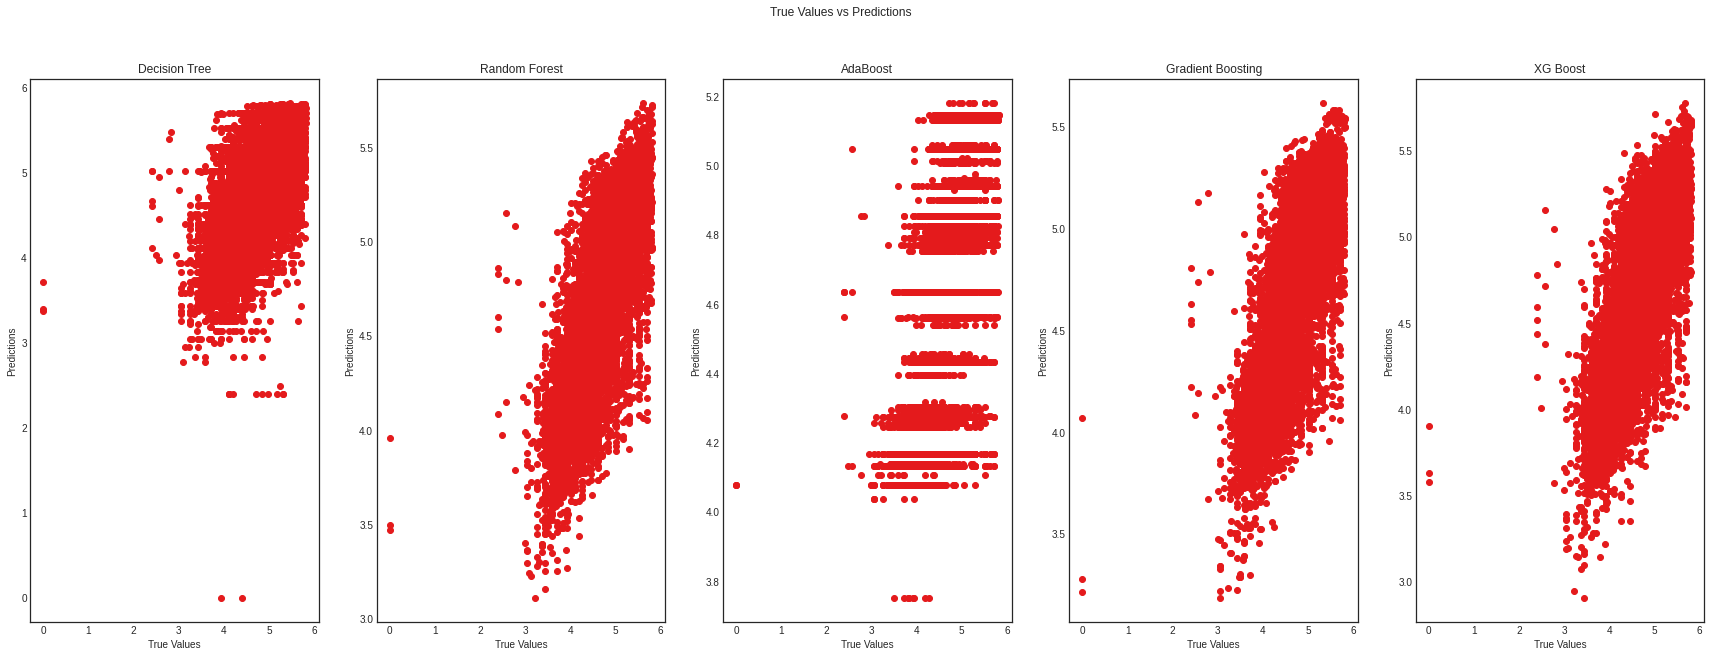

In [ ]:
fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(30, 10))
fig.suptitle('True Values vs Predictions')

ax1.scatter(y_test, dt_pred)
ax1.set_title('Decision Tree')

ax2.scatter(y_test, rf_pred)
ax2.set_title('Random Forest')

ax3.scatter(y_test, ada_pred)
ax3.set_title('AdaBoost')

ax4.scatter(y_test, gb_pred)
ax4.set_title('Gradient Boosting')

ax5.scatter(y_test, xg_pred)
ax5.set_title('XG Boost')



for ax in fig.get_axes():
    ax.set(xlabel='True Values', ylabel='Predictions')

In [60]:
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [97]:
# Create an instance of the LGBMRegressor model with default hyperparameters
model10 = LGBMRegressor(learning_rate=0.1, max_depth= 7, n_estimators = 150, num_leaves=31) #grid search was applied to choose those parameters 
#Best parameters found:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150, 'num_leaves': 31}

start=time()

# Fit the model to the training data
model10.fit(X_train, y_train)

# Make predictions on the testing data
rf_pred = model10.predict(X_test)

rf_pred2=(model10.predict(X_train))

# Evaluate the model performance on the testing data
print_score(y_test, rf_pred)

print_score(y_train,rf_pred2)

print(f"{round(time()-start, 2)}sec")

R²: 0.6551551971960687
RMSE: 0.3457483685879289
MSE: 0.11954193438121434
MAE: 0.2674544236665816
MAPE: 0.058928443188195526
R²: 0.7007577763529937
RMSE: 0.320003742917786
MSE: 0.10240239548139247
MAE: 0.24504072558384704
MAPE: 0.054075055796998596
0.81sec


In [99]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

# Define the LGBMRegressor model
model10 = LGBMRegressor()

# Define the parameters to tune
param_grid = {
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'num_leaves': [15, 31, 63]
}

# Define the GridSearchCV object
grid_search = GridSearchCV(model10, param_grid, cv=5)

start = time()

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Make predictions on the testing data
rf_pred = grid_search.predict(X_test)

# Evaluate the model performance on the testing data
print_score(y_test, rf_pred)

print(f"{round(time()-start, 2)}sec")

# Print the best parameters and the corresponding score
print("Best parameters found: ", grid_search.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_search.best_score_)))


R²: 0.6565647942189612
RMSE: 0.34504099975115654
MSE: 0.1190532915092776
MAE: 0.26601774400476463
MAPE: 0.05859884869741655
167.07sec
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150, 'num_leaves': 63}
Lowest RMSE found:  0.7998251804596413
